<a href="https://colab.research.google.com/github/CIGLR-ai-lab/GreatLakes-TempSensors/blob/main/notebooks/03_dcj_example_of_seasonal_cycle_decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.time import Time
import pandas as pd
import numpy as np

In [2]:
# Mounting Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Load data

In [3]:
# Set the path to the GLSEA3 data
fpath1 = '/content/gdrive/MyDrive/CIGLR Summer Fellows/DeepSensor-2024/sst-input-data-sample/GLSEA3_NETCDF/GLSEA3_2013.nc'
fpath2 = '/content/gdrive/MyDrive/CIGLR Summer Fellows/DeepSensor-2024/sst-input-data-sample/GLSEA3_NETCDF/GLSEA3_2014.nc'
fpath3 = '/content/gdrive/MyDrive/CIGLR Summer Fellows/DeepSensor-2024/sst-input-data-sample/GLSEA3_NETCDF/GLSEA3_2015.nc'

In [4]:
# Load three years for the purpose of this example
combined_ds = xr.open_mfdataset([fpath1, fpath2, fpath3],
                                concat_dim='time',
                                combine='nested',
                                chunks={'lat': 'auto', 'lon': 'auto'})

# Alternatively, you can load all the NetCDF files in a directory that match a certain pattern
#file_pattern = 'GLSEA3_20*.nc'
#combined_ds = xr.open_mfdataset(file_pattern, concat_dim='time', combine='nested')

In [5]:
print(combined_ds)

<xarray.Dataset>
Dimensions:  (time: 1094, lon: 1181, lat: 838)
Coordinates:
  * time     (time) datetime64[ns] 2013-01-01T12:00:00 ... 2015-12-31T12:00:00
  * lon      (lon) float64 -92.42 -92.41 -92.39 -92.38 ... -75.91 -75.9 -75.88
  * lat      (lat) float64 38.87 38.89 38.9 38.92 ... 50.56 50.58 50.59 50.61
Data variables:
    crs      (time) |S1 b'' b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b'' b''
    sst      (time, lat, lon) float32 dask.array<chunksize=(364, 255, 359), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    source:       2006_345_glsea.asc
    GDAL:         GDAL 2.1.3, released 2017/20/01
    NCO:          netCDF Operators version 4.7.5 (Homepage = http://nco.sf.ne...
    title:        SST from Great Lakes Surface Environmental Analysis (GLSEA)
    history:      Tue Feb 13 20:46:35 2024: cdo selyear,2013 GLSEA3_SST_2006_...
    CDO:          Climate Data Operators version 2.0.

## Calculate climatology

In [6]:
# Assuming combined_ds is your dataset with three dimensions with coordinates: time, lat, and lon

# 1. Calculate the daily climatology (daily mean seasonal cycle)
# First, group by day of year and then calculate the mean for each group
climatology = combined_ds.groupby('time.dayofyear').mean('time')

# We now have a daily climatology
print(climatology)

<xarray.Dataset>
Dimensions:    (lon: 1181, lat: 838, dayofyear: 365)
Coordinates:
  * lon        (lon) float64 -92.42 -92.41 -92.39 -92.38 ... -75.91 -75.9 -75.88
  * lat        (lat) float64 38.87 38.89 38.9 38.92 ... 50.56 50.58 50.59 50.61
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 359 360 361 362 363 364 365
Data variables:
    sst        (dayofyear, lat, lon) float32 dask.array<chunksize=(1, 255, 359), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.5
    source:       2006_345_glsea.asc
    GDAL:         GDAL 2.1.3, released 2017/20/01
    NCO:          netCDF Operators version 4.7.5 (Homepage = http://nco.sf.ne...
    title:        SST from Great Lakes Surface Environmental Analysis (GLSEA)
    history:      Tue Feb 13 20:46:35 2024: cdo selyear,2013 GLSEA3_SST_2006_...
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...


#### Plot time series at a selected location

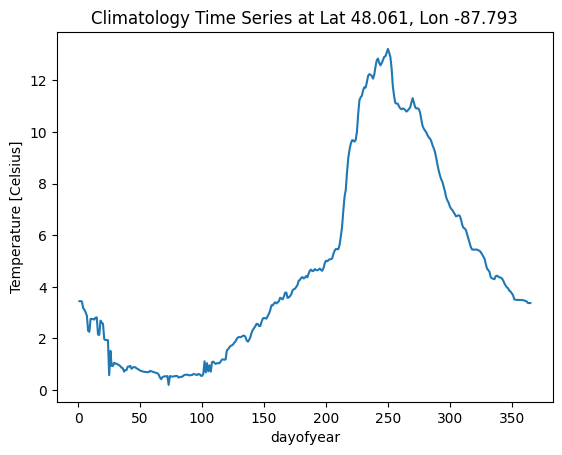

In [7]:
# Selecting a location in Lake Superior
lat_point = 48.061
lon_point = -87.793

# Extract the time series for the specific grid point from the climatology
climatology_ts = climatology.sel(lat=lat_point, lon=lon_point, method='nearest')

# Plot the climatology time series for this location
climatology_ts.sst.plot()
plt.title(f'Climatology Time Series at Lat {lat_point}, Lon {lon_point}')
plt.show()

#### Plot spatial map

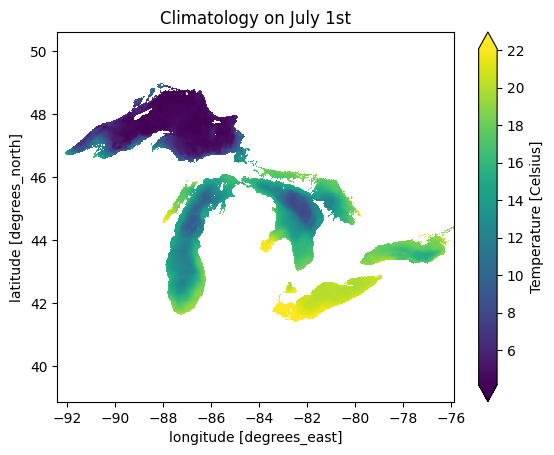

In [8]:
# Choose a specific day for the plot, e.g., July 1st as the 182nd day of the year (ignoring leap years)
day_of_year = 182

# Select the data for the day of year
selected_climatology = climatology.sel(dayofyear=day_of_year)

# Plot the climatology for that day
selected_climatology.sst.plot(x='lon', y='lat', robust=True)
plt.title('Climatology on July 1st')
plt.show()

## Calculate anomalies

In [9]:
# 2. Calculate the anomalies (departures from the seasonal cycle)
# Subtract the daily climatology from the original dataset
anomalies = combined_ds.groupby('time.dayofyear') - climatology

print(anomalies)

<xarray.Dataset>
Dimensions:    (time: 1094, lon: 1181, lat: 838)
Coordinates:
  * time       (time) datetime64[ns] 2013-01-01T12:00:00 ... 2015-12-31T12:00:00
  * lon        (lon) float64 -92.42 -92.41 -92.39 -92.38 ... -75.91 -75.9 -75.88
  * lat        (lat) float64 38.87 38.89 38.9 38.92 ... 50.56 50.58 50.59 50.61
    dayofyear  (time) int64 1 2 3 4 5 6 7 8 ... 358 359 360 361 362 363 364 365
Data variables:
    sst        (time, lat, lon) float32 dask.array<chunksize=(1, 255, 359), meta=np.ndarray>


#### Plot time series at a selected location (this crashes on Google Colab due to memory limitations - try it out on HPC)

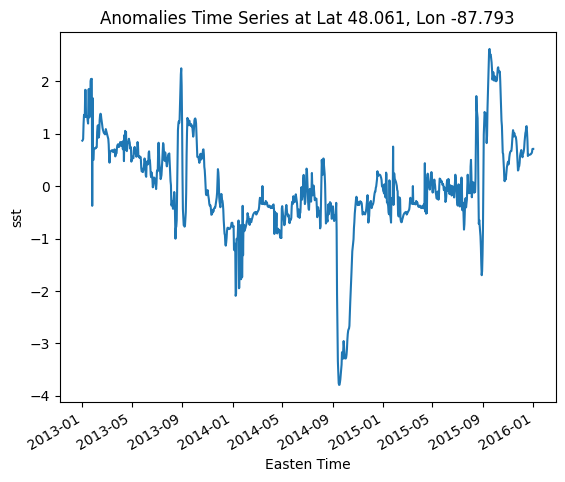

In [10]:
# Extract the time series for the specific grid point from the anomalies
anomalies_ts = anomalies.sel(lat=lat_point, lon=lon_point, method='nearest')

# Plot the anomalies time series for this location
anomalies_ts.sst.plot()
plt.title(f'Anomalies Time Series at Lat {lat_point}, Lon {lon_point}')
plt.show()

#### Plot spatial map of the anomalies on a selected day

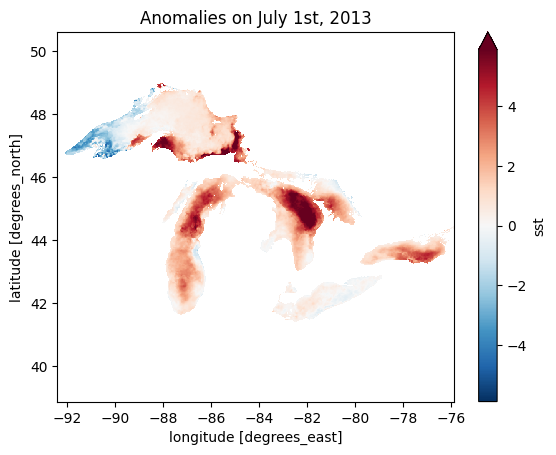

In [11]:
# Convert the desired date to a pandas.Timestamp to ensure compatibility with xarray's indexes
selected_date = pd.Timestamp('2013-07-01')

# Select the data for the specific date
selected_anomalies = anomalies.sel(time=selected_date, method='nearest')

# Plot the anomalies for that day
selected_anomalies.sst.plot(x='lon', y='lat', robust=True)
plt.title('Anomalies on July 1st, 2013')
plt.show()